# Classifying Names with a Character-Level RNN 

#### http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Preparing the Data

In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): 
    ## glob用于查找符合特定规则的文件路径名
    return glob.glob(path)

files = findFiles('data/RNN_names/names/*.txt')
print(files)

['data/RNN_names/names/Korean.txt', 'data/RNN_names/names/Chinese.txt', 'data/RNN_names/names/Japanese.txt', 'data/RNN_names/names/Polish.txt', 'data/RNN_names/names/Portuguese.txt', 'data/RNN_names/names/Greek.txt', 'data/RNN_names/names/English.txt', 'data/RNN_names/names/Italian.txt', 'data/RNN_names/names/German.txt', 'data/RNN_names/names/Czech.txt', 'data/RNN_names/names/Dutch.txt', 'data/RNN_names/names/Arabic.txt', 'data/RNN_names/names/Vietnamese.txt', 'data/RNN_names/names/Scottish.txt', 'data/RNN_names/names/Irish.txt', 'data/RNN_names/names/French.txt', 'data/RNN_names/names/Spanish.txt', 'data/RNN_names/names/Russian.txt']


In [17]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
# remove all the accents (diacritics声调) in string
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in files:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('<---(category, num)--->')
print(list(zip(all_categories, [len(category_lines[category]) for category in all_categories])))

Slusarski
<---(category, num)--->
[('Korean', 94), ('Chinese', 268), ('Japanese', 991), ('Polish', 139), ('Portuguese', 74), ('Greek', 203), ('English', 3668), ('Italian', 709), ('German', 724), ('Czech', 519), ('Dutch', 297), ('Arabic', 2000), ('Vietnamese', 73), ('Scottish', 100), ('Irish', 232), ('French', 277), ('Spanish', 298), ('Russian', 9408)]


In [18]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors 

In [22]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print('<--Letter \'J\' to Tensor-->')
print(letterToTensor('J'))

print('<--Name \'Jones\' to Tensor-->')
print(lineToTensor('Jones').size())

<--Letter 'J' to Tensor-->


Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

<--Name 'Jones' to Tensor-->
torch.Size([5, 1, 57])


## Creating the Network

In [25]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128)
  (i2o): Linear(in_features=185, out_features=18)
  (softmax): LogSoftmax()
)


In [33]:
input = Variable(letterToTensor('Albert'))
# hidden state initialized as zeros at first
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)
# every item in output is the likelihood of that category (higher is more likely)
# note that the model has not been train yet
print(output)

Variable containing:

Columns 0 to 9 
-2.8816 -2.9671 -2.8503 -2.9129 -2.8631 -2.9907 -2.8257 -2.8612 -2.8919 -2.9241

Columns 10 to 17 
-2.8148 -2.9024 -2.9934 -2.9065 -2.8280 -2.8472 -2.9464 -2.8454
[torch.FloatTensor of size 1x18]



## Training 

## Preparing for Training

In [36]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 10)


In [38]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Beaumont
category = Dutch / line = Ryskamp
category = German / line = Tobias
category = Korean / line = Baik
category = German / line = Goebel
category = Scottish / line = Mcintosh
category = German / line = Faust
category = Czech / line = Michalovic
category = Greek / line = Bekyros
category = Greek / line = Alexandropoulos


## Training the Network

In [39]:
criterion = nn.NLLLoss()

In [40]:
# Each loop of training will:
# Create input and target tensors
# Create a zeroed initial hidden state
# Read each letter in and
# Keep hidden state for next letter
# Compare final output to target
# Back-propagate
# Return the output and loss
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [48]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 2% (0m 6s) 0.5474 Baldi / Italian ✓
10000 5% (0m 12s) 0.1889 Vyjutovich / Russian ✓
15000 7% (0m 19s) 2.1576 Kwan / Korean ✗ (Chinese)
20000 10% (0m 26s) 4.3529 Raskop / Czech ✗ (German)
25000 12% (0m 32s) 1.0073 Sneijer / Dutch ✓
30000 15% (0m 37s) 0.0232 Balboni / Italian ✓
35000 17% (0m 43s) 0.7790 Chu / Vietnamese ✓
40000 20% (0m 48s) 2.5188 Friedrich / Russian ✗ (Czech)
45000 22% (0m 53s) 0.4439 Vlasek / Czech ✓
50000 25% (0m 59s) 0.8104 Murphy / Scottish ✓
55000 27% (1m 4s) 2.8485 Jordan / English ✗ (German)
60000 30% (1m 9s) 4.8124 Katz / German ✗ (Russian)
65000 32% (1m 15s) 0.2501 Yanagita / Japanese ✓
70000 35% (1m 21s) 2.0056 Yeomans / Dutch ✗ (English)
75000 37% (1m 27s) 0.1495 Xie / Chinese ✓
80000 40% (1m 33s) 0.7311 Wawrzaszek / Polish ✓
85000 42% (1m 38s) 2.0324 Santos / Portuguese ✗ (Spanish)
90000 45% (1m 44s) 2.7458 Chishu / Chinese ✗ (Japanese)
95000 47% (1m 49s) 1.2479 Friedrich / German ✓
100000 50% (1m 55s) 4.4779 Sip / Korean ✗ (Czech)
105000 52% (2m 1s) 0.

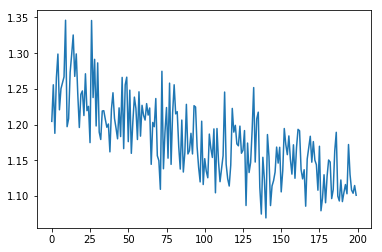

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.figure()
plt.plot(all_losses)

## Evaluating the Results 

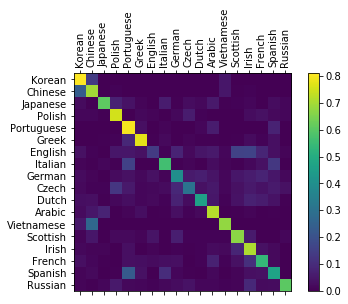

In [46]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Running on User Input

In [47]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.81) Czech
(-1.50) Russian
(-1.62) Polish

> Jackson
(-0.60) Scottish
(-1.44) English
(-2.74) Russian

> Satoshi
(-1.12) Japanese
(-1.50) Italian
(-1.61) Arabic
